# PINN Implementation
This Jupyter notebook attempts to incorporate a general PINN algorithm, generally made from different sources that I have found, focussing on the development of the neural network using PyTorch.
All papers are to be accurately cited for bits of codes that I have extracted.

## Environment Setup

In [1]:
from PIL import Image

#import sys
#!{sys.executable} -m pip install deepxde

%env  DDE_BACKEND=pytorch

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import deepxde as dde



torch.manual_seed(1234)
np.random.seed(1234)


env: DDE_BACKEND=pytorch


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


## Part I - Solving the 1D Poisson Equation
We will first solve the 1D Poisson equation through training and compare it with the FDM method and the actual solution. This part comes from the paper regarding GRINN.

In [2]:
## We test the solution of the POISSON's EQN
#Set data type
DTYPE=torch.float32
torch.set_default_dtype(DTYPE)

lam = 1.0          # one wavelength
const = 1 ## we set 4 pi G  tp 1
num_of_waves = 2

rho_1 = 0.03;       # question 2b non-linear wave propagation
rho_o = 1          # zeroth order density
def pdeTest(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return dy_xx - const*(rho_1 * torch.cos(2*np.pi*x/lam))

Compiling model...
'compile' took 0.314973 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [4.02e-02, 1.21e-01, 1.85e-01]    [4.02e-02, 1.21e-01, 1.85e-01]    []  
1000      [3.33e-04, 3.57e-10, 9.43e-07]    [3.33e-04, 3.57e-10, 9.43e-07]    []  
2000      [2.96e-04, 3.74e-10, 7.34e-07]    [2.96e-04, 3.74e-10, 7.34e-07]    []  
3000      [7.30e-05, 4.78e-11, 2.30e-07]    [7.30e-05, 4.78e-11, 2.30e-07]    []  

Best model at step 3000:
  train loss: 7.32e-05
  test loss: 7.32e-05
  test metric: []

'train' took 23.040987 s

Compiling model...
'compile' took 0.000415 s

Training model...

Step      Train loss                        Test loss                         Test metric
3000      [7.30e-05, 4.78e-11, 2.30e-07]    [7.30e-05, 4.78e-11, 2.30e-07]    []  
4000      [1.78e-07, 1.46e-12, 1.92e-10]    [1.78e-07, 1.46e-12, 1.92e-10]    []  
5000      [1.51e-07, 3.93e-12, 1.54e-10]    [1.51e-07, 3.93e-12, 1.54e-10]  

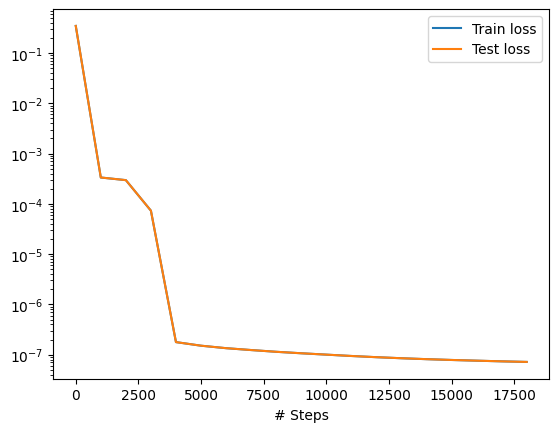

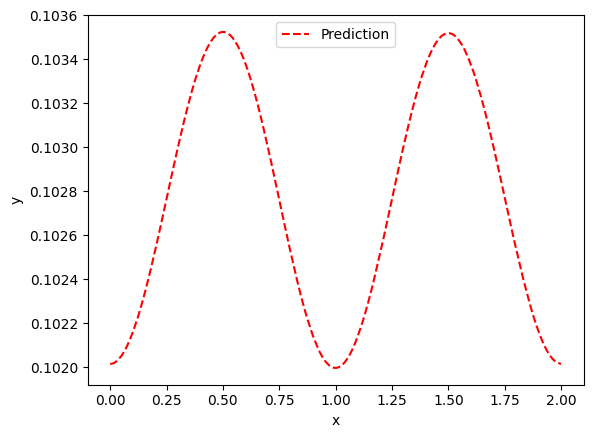

In [3]:
## The Geometric Domain
xmin = 0
xmax = xmin + lam * num_of_waves
geom = dde.geometry.Interval(xmin, xmax)
# geom = dde.geometry.Interval(-1, 1)


## Boundaries

## Note in the deep XDE code by default for the periodic boundary u(0) = u(1)
## If the problem is periodic this condition will also satisfy u(-1) = u(1)
## Thus is most cases the left boundary is not needed. But we have the option here

def boundary_l(x, on_boundary):  # boundary x=-1 or x = 0
    if xmin == -1:
        is_on_boundary_left = on_boundary and np.isclose(x[0], xmin)
    else:
        is_on_boundary_left = on_boundary and np.isclose(x[0], 0)
    return is_on_boundary_left

def boundary_r(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], xmax)

    return is_on_boundary_right


bc_l = dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=0) ## may be used when x = [-1,1] otherwise for x =[0,1] not needed
bc_r = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=0)

## 1st order terms

bc_ll = dde.icbc.PeriodicBC(geom, 0, boundary_l,derivative_order=1) ##may be used when x = [-1,1]
bc_rr = dde.icbc.PeriodicBC(geom, 0, boundary_r,derivative_order=1)

data = dde.data.TimePDE(geom,
                     pdeTest,
#                     [bc_l,bc_r,bc_ll,bc_rr], ## This is needed if one need to force periodicity on the left
                     [bc_r,bc_rr],          ## For x =[0,1] and default
                     num_domain=10000,
                     num_boundary=5000
                     #num_initial=5000,
                    # num_test=10000,
                   )

net = dde.nn.FNN([1] + [32] * 3 + [1], "sin", "Glorot normal")
model_test = dde.Model(data, net)

model_test.compile("adam", lr=1e-3)
model_test.train(iterations=3000)
model_test.compile("L-BFGS")


losshistory, train_state = model_test.train()
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

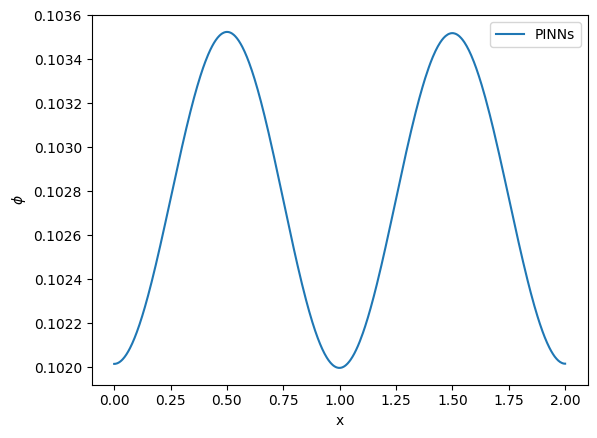

In [4]:
X = np.linspace(xmin,xmax,1000).reshape(1000, 1)
output_0 = model_test.predict(X)
plt.plot(X,output_0,label="PINNs")
plt.ylabel(r"$\phi$")
plt.xlabel("x")
plt.legend()

Now for the classic interpretation:

In [5]:
def fft_solver(rho,Lx,N, dim = None):

    '''
    A FFT solver that uses discrete Fast Fourier Transform to
    solve the poisson Equation:
    We apply the correction due to the finite difference grid of phi

    Input: 1. The source function: density in this case
           2. # of grid point N
           3. Domain Size in each dimension

    Output: the potential phi and the field g

    '''
    nx = N
    Lx = Lx

    dx = Lx / nx


    # Calculate the Fourier modes of the gas density
    rhohat = fft(rho)

    # Calculate the wave numbers in x and y directions
    kx = 2 * np.pi * np.fft.fftfreq(nx, dx)
    #ky = 2 * np.pi * np.fft.fftfreq(ny, dy)

    # Construct the Laplacian operator in Fourier space
    kx2 = np.meshgrid(kx**2)

#     laplace = -(kx**2 )
    ## Laplace with the correction refer to the notes
    laplace = 2*(np.cos(kx*dx)-1)

    ## Inorder to avoid the inf we replace zero with a small number
    laplace[laplace == 0] = 1e-16

    # Solve for the gravitationa potential in Fourier space
    phihat = rhohat / laplace

    phihat = rhohat * dx**2/laplace
#     window = signal.windows.tukey(len(phihat),alpha=0.25)


    # Transform back to real space to obtain the solution
#     phi = np.real(ifft(phihat*window))
    phi = np.real(ifft(phihat))

    ## The field ,i.e., gravity
    dphidx = np.gradient(phi, dx)

    return phi,dphidx

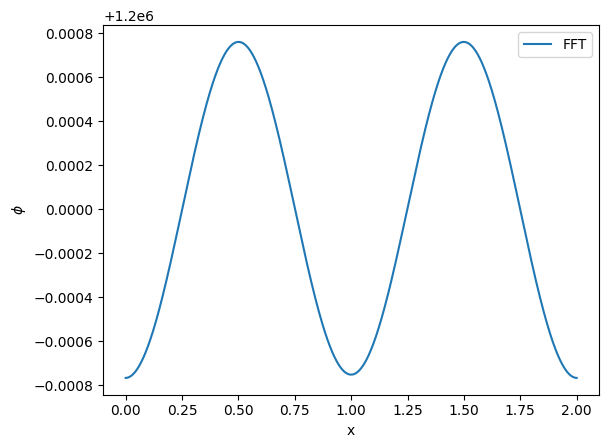

In [6]:
from numpy.fft import fft, ifft
from scipy import signal
L = lam * num_of_waves
N = 1000
x = np.linspace(0, L, N)
rho = rho_1 * np.cos(2*np.pi*x/lam)

phi, dpidx  = fft_solver(const*(rho),L,N, dim = None)
plt.plot(x,phi,label="FFT")
plt.ylabel(r"$\phi$")
plt.xlabel("x")
plt.legend()